In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
import cv2
from IPython.display import display, clear_output

In [35]:
style_img_path = "73_1512370455mg0oL.jpg"
content_img_path  = "nature-3696335_1280.jpg"

In [36]:
# loading images from given location
def load_image(img_path, reshape=(512, 512)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, reshape)
    return img

In [37]:
style_img = load_image(style_img_path)
content_img = load_image(content_img_path)

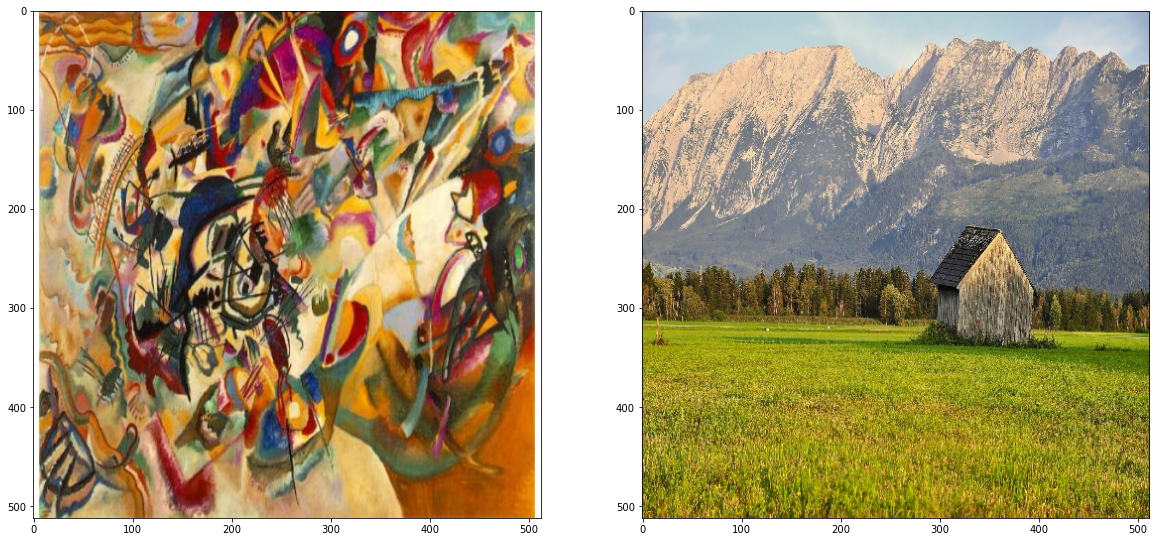

In [38]:
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(style_img)
plt.subplot(122)
plt.imshow(content_img)

In [26]:
# parameters
CONTENT_LAYERS = [
    "block4_conv2"
]

STYLE_LAYERS = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"
]

WL = [1/len(STYLE_LAYERS)] * len(STYLE_LAYERS)

In [8]:
# defining the models
def get_model(LAYERS):
    base_model = vgg19.VGG19(include_top=False, weights="imagenet")
    base_model.trainable= False
    output_layers = [ base_model.get_layer(layer).output for layer in LAYERS ]
    return Model(base_model.input, output_layers)

In [9]:
CONTENT_LAYERS + STYLE_LAYERS

['block4_conv2',
 'block1_conv1',
 'block2_conv1',
 'block3_conv1',
 'block4_conv1',
 'block5_conv1']

In [10]:
# style_model = get_model(STYLE_LAYERS)
# content_model = get_model(CONTENT_LAYERS)
generate_model = get_model(CONTENT_LAYERS + STYLE_LAYERS)

In [11]:
# preprocessing and reverse processing 
def preprocess(img):
    return vgg19.preprocess_input(np.expand_dims(img,axis=0))

def reverse_preprocess(img):
    bias = vgg19.preprocess_input((np.zeros((3))).astype("float32"))
    img = img - bias
    img = tf.unstack(img,axis=-1)
    img = tf.stack([img[2],img[1],img[0]],axis=-1)
    return img

In [12]:
# helper functions 
def compute_content_cost(a_C, a_G):
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C, a_G))) / 2
    return J_content

def get_gram_matrix(mat):
    A = tf.reshape(mat,(-1,mat.shape[-1])) 
    n = A.shape[0]
    gram_matrix = tf.matmul(A, A, transpose_a=True)
    n = gram_matrix.shape[0]
    return gram_matrix / tf.cast(n,"float32"), n

def get_style_loss(a_G, a_S):
    GG, GGn = get_gram_matrix(a_G)
    GS, GSn = get_gram_matrix(a_S)

    nf = GG.shape[0]
    loss = tf.reduce_sum(tf.square(GS - GG) / (4*(GSn**2)*(nf**2)))
    return loss

def get_total_loss(a_G, a_C, a_S, style_weights, alpha = 1e-4, beta=1e-2):

    style_loss=0
    N = len(a_S)
    for i in range(N):
        style_loss += style_weights[i] * get_style_loss(a_G[i+1], a_S[i])
        
    content_loss = compute_content_cost(a_C, a_G[0])
    
    return alpha * content_loss + beta * style_loss

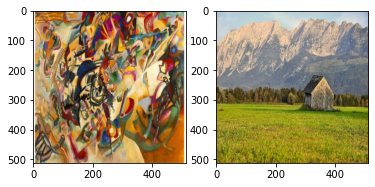

In [39]:
# init
processed_style = preprocess(style_img)
processed_content = preprocess(content_img)

a_S = generate_model(processed_style)[1:]
plt.subplot(121)
plt.imshow(np.round(reverse_preprocess(processed_style)[0])/255)

a_C = generate_model(processed_content)[0]
plt.subplot(122)
plt.imshow(np.round(reverse_preprocess(processed_content)[0])/255)

a_G = tf.Variable(processed_content)

optimizer = tf.optimizers.Adam(5)

images = []
losses =[]

In [40]:
best_loss = 1e20
bias = vgg19.preprocess_input((np.zeros((3))).astype("float32"))
min_vals = bias
max_vals = 255 + bias
for i in range(200):   
    with tf.GradientTape() as tape:
        tape.watch(a_G)
        a_G_out = generate_model(a_G)
        loss = get_total_loss(a_G_out, a_C, a_S, WL, alpha=1e-6, beta=1e-2)
        grad = tape.gradient(loss, a_G)
        losses.append(loss)
        optimizer.apply_gradients(zip([grad],[a_G]))
        clipped = tf.clip_by_value(a_G, min_vals, max_vals)
        a_G.assign(clipped)
        if i%5 ==0:
            images.append(reverse_preprocess(a_G))
        if loss < best_loss:
            best_image = a_G
            best_loss = loss
        display(i, loss)
        clear_output(wait=True)

199

<tf.Tensor: shape=(), dtype=float32, numpy=85969.945>

In [41]:
deprocessed_best_image = reverse_preprocess(best_image)

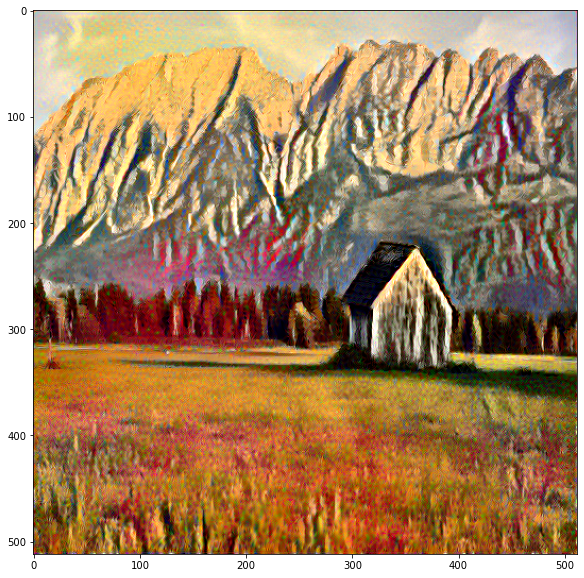

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(reverse_preprocess(best_image)[0] / 255))

In [43]:
np.array(reverse_preprocess(best_image)[0] / 255).shape

(512, 512, 3)

In [44]:
import matplotlib

matplotlib.image.imsave('oily_nature.png', np.array(reverse_preprocess(best_image)[0] / 255))
matplotlib.image.imsave('oil_painting.png', np.array(reverse_preprocess(processed_style)[0] / 255))
matplotlib.image.imsave('nature.png', np.array(reverse_preprocess(processed_content)[0] / 255))